In [128]:
# Core data handling libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#%matplotlib inline

# For modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#For saving the model
import joblib

# Data Loading and Initial Inspection

### Load the dataset

In [129]:
df = pd.read_csv('../data/shipping-data.csv')

### Display basic information

In [130]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   OrderID              1000 non-null   object
 1   Client_Name          1000 non-null   object
 2   Destination_Country  1000 non-null   object
 3   Shipment_Type        1000 non-null   object
 4   Weight_lbs           1000 non-null   int64 
 5   Length_in            1000 non-null   int64 
 6   Width_in             1000 non-null   int64 
 7   Height_in            1000 non-null   int64 
 8   Carrier_Service      1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB
None


### Display the first few rows

In [131]:
print(df.head())

    OrderID         Client_Name Destination_Country Shipment_Type  Weight_lbs  \
0  ORD-0001    CanuckIndustries              Canada        Pallet         431   
1  ORD-0002           MexiSteel              Mexico         Crate        1269   
2  ORD-0003     IndiaSteelworks               India           Box          41   
3  ORD-0004           UKConnect      United Kingdom        Pallet         521   
4  ORD-0005  BrazilliaMachinery              Brazil         Crate         973   

   Length_in  Width_in  Height_in                      Carrier_Service  
0         31        28         49                      ABF Freight LTL  
1         61        21         24                             SAIA LTL  
2         21        19         10                    UPS Express Saver  
3         41        31         30                DHL Worldwide Express  
4         43        45         45  FedEx International Economy Freight  


# Data Cleaning and Wrangling

### Clean string columns
Strip potential leading/trailing whitespace and normalize internal whitespace for all object (string) type columns.

In [132]:
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.strip().str.replace('\s+', ' ', regex=True)

### Verify a few carrier names after cleaning

In [133]:
print(df['Carrier_Service'].unique()[:10])

['ABF Freight LTL' 'SAIA LTL' 'UPS Express Saver' 'DHL Worldwide Express'
 'FedEx International Economy Freight' 'FedEx Priority Freight LTL'
 'FedEx Ground' 'FedEx International Priority'
 'FedEx International Economy' 'FedEx International Priority Freight']


### Use the .describe() method to generate and print a statistical summary

In [134]:
summary_stats = df.describe()
print(summary_stats)

        Weight_lbs    Length_in     Width_in    Height_in
count  1000.000000  1000.000000  1000.000000  1000.000000
mean    489.882000    34.083000    23.370000    29.474000
std     426.090132    13.626878     9.504496    15.071114
min       1.000000    12.000000     7.000000     7.000000
25%     123.000000    24.000000    16.000000    15.000000
50%     334.500000    31.000000    23.000000    30.000000
75%     927.000000    43.000000    30.000000    42.000000
max    1299.000000    69.000000    48.000000    59.000000


### Generate a correlation heatmap

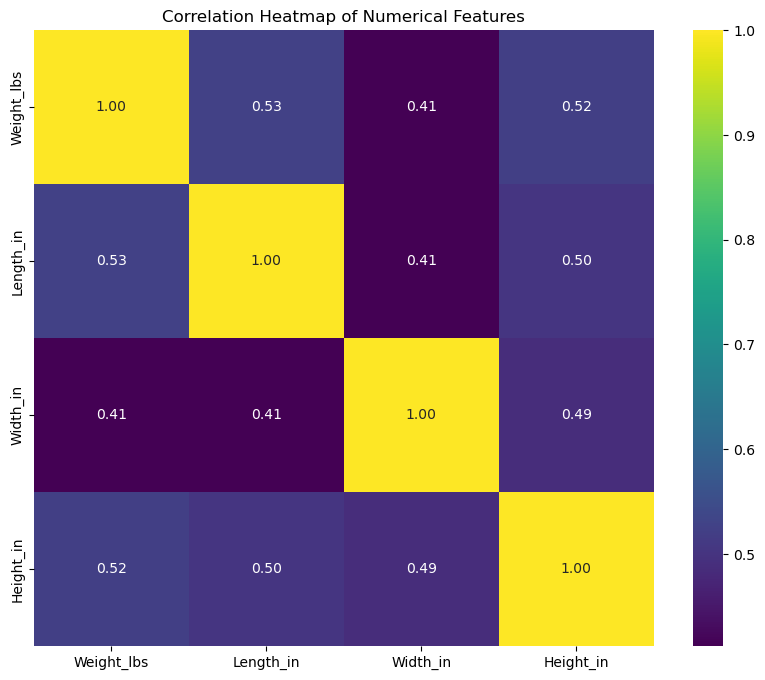

In [135]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='viridis', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# Feature Engineering: Creating Predictive Power ("Insider Knowledge")

Raw features are often not the most predictive. When it comes to making decisions in logistics, two engineered features will be particularly useful — volume and density.

Volume: Calculated as Length x Width x Height. This metric directly quantifies the physical space a shipment occupies, which is an important factor in cost and handling.

Density: Calculated as Weight/Volume. This metric distinguishes between items that are small and heavy (like a small box of metal parts) versus those that are large and light (like a large box of hollow PVC valve casings), which very often dictates the type of handling and carrier required.

## Feature Engineering

In [136]:
df['Volume_cubic_in'] = df['Length_in'] * df['Width_in'] * df['Height_in']

### Calculating density and avoiding division by zero for any potential volume of 0

In [137]:
df['Density_lbs_per_cubic_in'] = df['Weight_lbs'] / (df['Volume_cubic_in'] + 1e-6)

### Display descriptive statistics including new features

In [138]:
descriptive_stats = df.describe()
print(descriptive_stats)

        Weight_lbs    Length_in     Width_in    Height_in  Volume_cubic_in  \
count  1000.000000  1000.000000  1000.000000  1000.000000      1000.000000   
mean    489.882000    34.083000    23.370000    29.474000     29237.282000   
std     426.090132    13.626878     9.504496    15.071114     23995.990297   
min       1.000000    12.000000     7.000000     7.000000       637.000000   
25%     123.000000    24.000000    16.000000    15.000000      5278.000000   
50%     334.500000    31.000000    23.000000    30.000000     27000.000000   
75%     927.000000    43.000000    30.000000    42.000000     48000.000000   
max    1299.000000    69.000000    48.000000    59.000000    123861.000000   

       Density_lbs_per_cubic_in  
count               1000.000000  
mean                   0.026189  
std                    0.030173  
min                    0.000238  
25%                    0.009085  
50%                    0.014706  
75%                    0.035265  
max                    0.

# Preprocessing for Modeling

### Model 1: Shipment Type Classifier

In [139]:
# Define the features (X1) and target (y1) for the first model
X1 = df[['Weight_lbs', 'Length_in', 'Width_in', 'Height_in', 'Volume_cubic_in', 'Density_lbs_per_cubic_in']]
y1 = df['Shipment_Type']

# Split the data for Model 1
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42, stratify=y1)

# Train the classifier
shipment_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
shipment_classifier.fit(X1_train, y1_train)

# Evaluate the classifier
y1_pred = shipment_classifier.predict(X1_test)
print("--- Shipment Classifier Performance ---")
print(classification_report(y1_test, y1_pred))

--- Shipment Classifier Performance ---
              precision    recall  f1-score   support

         Box       1.00      1.00      1.00        70
       Crate       1.00      0.94      0.97        71
      Pallet       0.94      1.00      0.97        59

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200



### Model 2: Carrier Predictor

In [140]:
# Add the prediction from Model 1 as a new feature
df['predicted_shipment_type'] = shipment_classifier.predict(X1)

# Define features and target for the second model
categorical_features = ['Client_Name', 'Destination_Country', 'predicted_shipment_type']
numerical_features = ['Weight_lbs', 'Length_in', 'Width_in', 'Height_in', 'Volume_cubic_in', 'Density_lbs_per_cubic_in']
X2 = df[categorical_features + numerical_features]
y2 = df['Carrier_Service']

# The target variable (y2) is text, so it needs to be encoded into numbers for the model
le = LabelEncoder()
y2_encoded = le.fit_transform(y2)

# Split the data for Model 2
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2_encoded, test_size=0.2, random_state=42, stratify=y2_encoded)

# Create a preprocessing pipeline to handle categorical and numerical features differently
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Create the full prediction pipeline, which first preprocesses the data and then runs the classifier
carrier_predictor = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the final pipeline
carrier_predictor.fit(X2_train, y2_train)

# Make predictions and evaluate Model 2
y2_pred = carrier_predictor.predict(X2_test)
print("\n--- Carrier Predictor Performance ---")
print(f"Accuracy: {accuracy_score(y2_test, y2_pred):.4f}")
print(classification_report(y2_test, y2_pred, target_names=le.classes_, zero_division=0))


--- Carrier Predictor Performance ---
Accuracy: 0.9850
                                      precision    recall  f1-score   support

                     ABF Freight LTL       1.00      1.00      1.00        13
               DHL Worldwide Express       0.92      0.96      0.94        24
           FedEx Economy Freight LTL       1.00      1.00      1.00         7
                        FedEx Ground       1.00      1.00      1.00         7
         FedEx International Economy       1.00      1.00      1.00        15
 FedEx International Economy Freight       1.00      1.00      1.00        35
        FedEx International Priority       1.00      1.00      1.00        13
FedEx International Priority Freight       0.96      0.92      0.94        24
          FedEx Priority Freight LTL       1.00      1.00      1.00        21
            FedEx Priority Overnight       1.00      1.00      1.00         3
                            SAIA LTL       1.00      1.00      1.00        20
       

### Check the training accuracy to compare with test accuracy and check for overfitting

In [141]:
print("\n--- Overfitting Check ---")

# Check the training accuracy for the first model
train_accuracy_model1= shipment_classifier.score(X1_train, y1_train)
test_accuracy_model1 = shipment_classifier.score(X1_test, y1_test)
print(f"Shipment Classifier Training Accuracy: {train_accuracy_model1:.4f}")
print(f"Shipment Classifier Testing Accuracy: {test_accuracy_model1:.4f}")

print("-" * 20)

# Check the training accuracy for the second model
train_accuracy_model2 = carrier_predictor.score(X2_train, y2_train)
test_accuracy_model2 = carrier_predictor.score(X2_test, y2_test)
print(f"Carrier Predictor Training Accuracy: {train_accuracy_model2:.4f}")
print(f"Carrier Predictor Testing Accuracy: {test_accuracy_model2:.4f}")


--- Overfitting Check ---
Shipment Classifier Training Accuracy: 1.0000
Shipment Classifier Testing Accuracy: 0.9800
--------------------
Carrier Predictor Training Accuracy: 1.0000
Carrier Predictor Testing Accuracy: 0.9850


### Serialization: Packaging Models for Production
Save the models and encoders. The preprocessor is already part of the carrier_predictive pipeline, so it gets saved with it.

In [ ]:
joblib.dump(shipment_classifier, '../models/shipment_classifier.joblib')
joblib.dump(carrier_predictor, '../models/carrier_predictor.joblib')
joblib.dump(le, '../models/carrier_label_encoder.joblib')